In [1]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import RELU, ADD, GEMM, CONV2D
from operators_attn import Logit, Attend
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part B.1: Operator Fusion - 4 points
-	Implementing operator fusion
-	Identifying various fusion operations opportunities among different operations.


Part B.2: Dataflow aware roofline - 4 points.
-	A stationary
-	B stationary
-	C stationary
-	Bonus – 1 point

Part B.3: Quantization of data – 2 points
-	Data fetch quantization
-	Quantization with different compute units.




In [2]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=314, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)

## B.1 Operator Fusion
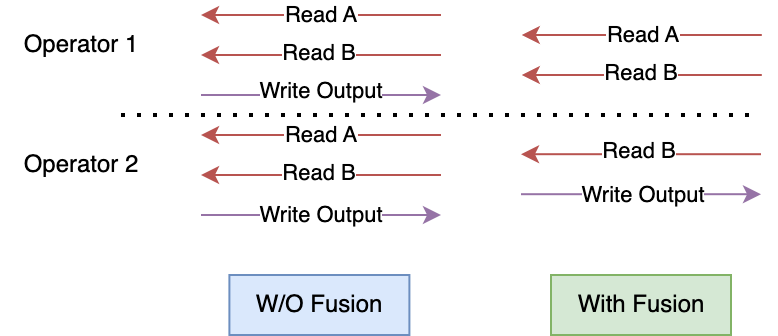

#### TODO B.1.i) Implement operator fusion

In [3]:
model_b1i = [
            GEMM([1, 128, 128, 512 ]),
            GEMM([1, 128, 10240, 128 ]),
            GEMM([1, 128, 1, 10240 ])
            ]
model_b1i_wo_fusion = analysis_model(model_b1i, A100_GPU, fusion = [])
display(model_b1i_wo_fusion)
print(f'Total Cycles:{sum(model_b1i_wo_fusion.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b1i_wo_fusion.loc[:, "Total Data (MB)"]):0.2f}')

model_b1i_with_fusion = analysis_model(model_b1i, A100_GPU, fusion = [(0,1),(1,2)])
display(model_b1i_with_fusion)
print(f'Total Cycles:{sum(model_b1i_with_fusion.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b1i_with_fusion.loc[:, "Total Data (MB)"]):0.2f}')

model_b1i_with_fusion.to_csv('output_b1.csv', index=False)

16777216   157000000000000.0
335544320   157000000000000.0
2621440   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 128, 128, 512]",M,0.70,113.78,0.00,222.04,16.78,0.06,0.06,0.02,0.14,82.74,156.02,222.04
1,GEMM,"[1, 128, 10240, 128]",M,0.79,127.20,0.00,3972.02,335.54,0.02,1.25,1.25,2.52,92.50,3120.35,3972.02
2,GEMM,"[1, 128, 1, 10240]",M,0.01,1.98,0.00,1989.28,2.62,1.25,0.01,0.00,1.26,1.44,24.38,1989.28


Total Cycles:6183.34, Total data (MB): 3.92
16777216   157000000000000.0
335544320   157000000000000.0
2621440   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 128, 128, 512]",M,0.79,113.78,0.00,197.37,16.78,0.06,0.06,0.02,0.14,93.08,156.02,197.37
1,GEMM,"[1, 128, 10240, 128]",C,1.58,127.20,0.00,3120.35,335.54,0.02,1.25,1.25,2.52,117.75,3120.35,1973.67
2,GEMM,"[1, 128, 1, 10240]",C,1.56,1.98,0.00,24.38,2.62,1.25,0.01,0.00,1.26,117.75,24.38,15.61


Total Cycles:3342.09, Total data (MB): 3.92


### TODO B.1.ii) Finding best fusion strategy.

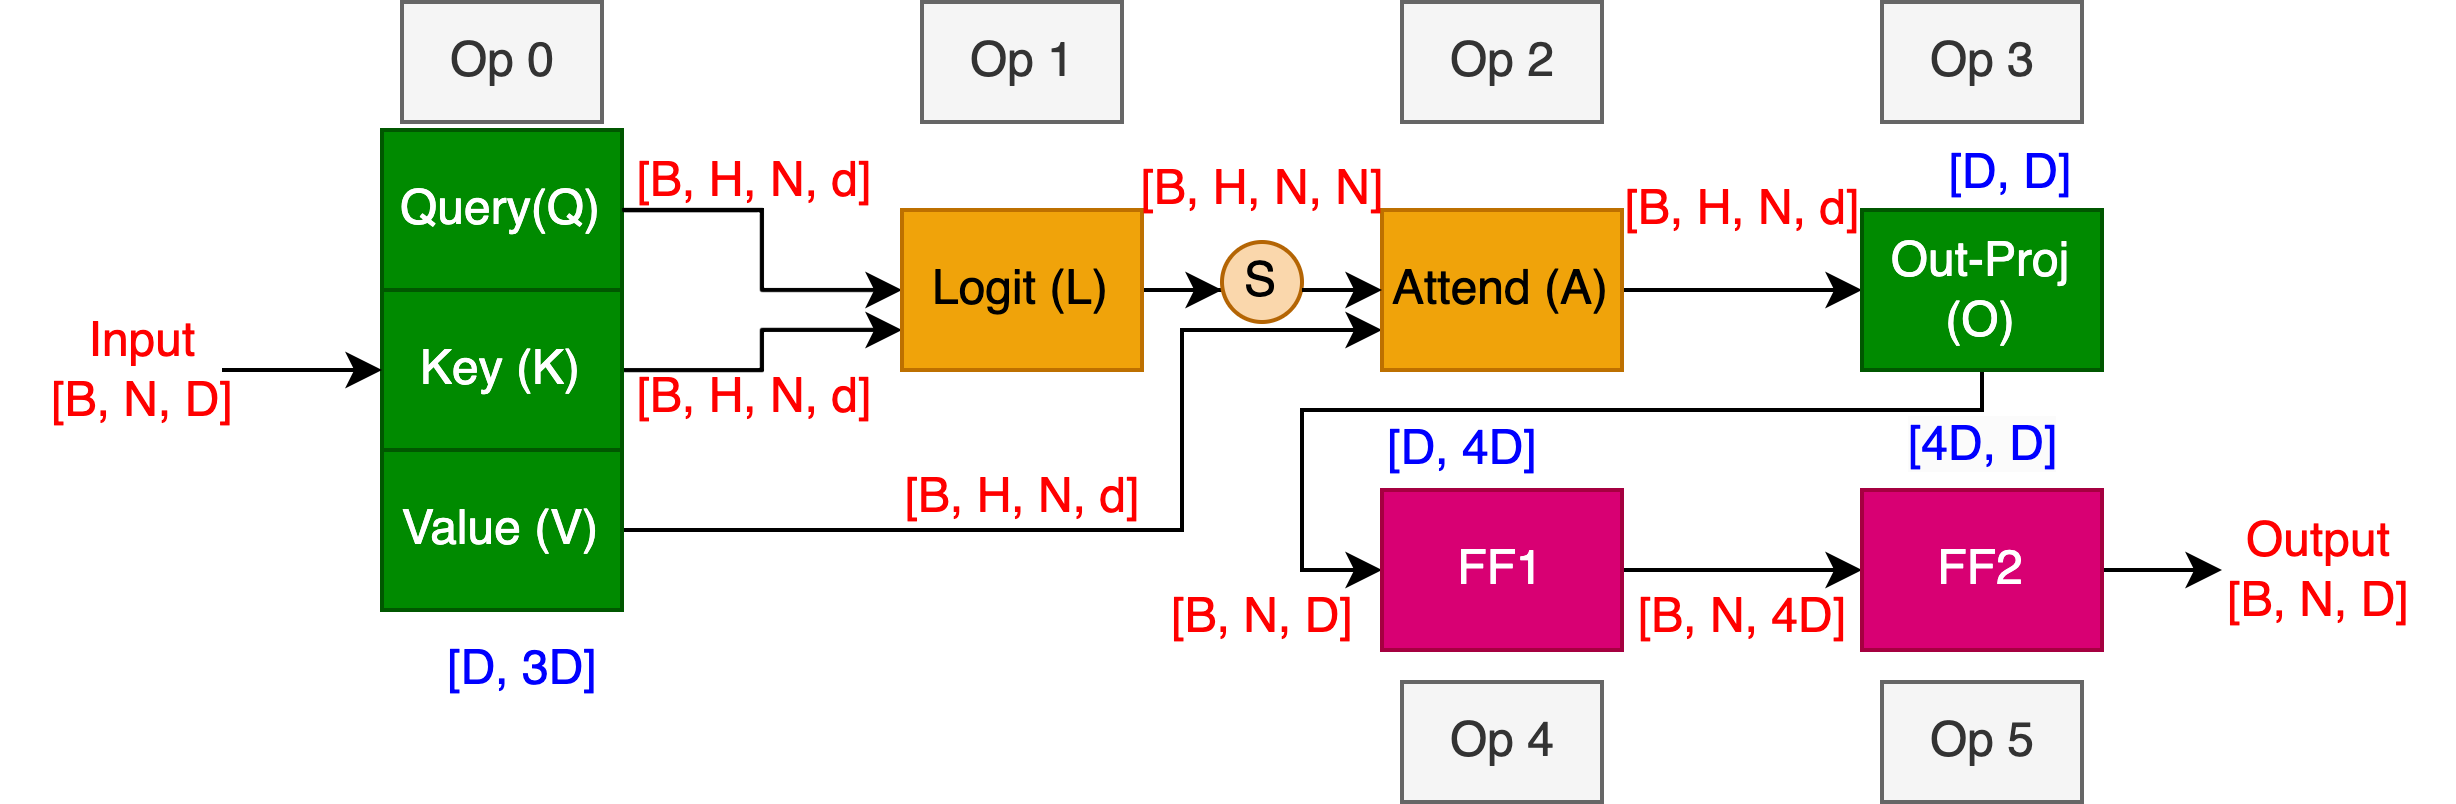

Figure: A typical transformer layer. We show  6 matrix multiplication operations in the figure. All weights dimensions are shown in blue color and activations are shown in red color. Note: we ignore the add operations for simplicity.

You are allowed to perform any number of legal pairwise fusions. Legal pairwise fusion is fusing any 2 operations that are connected in the graph by arrow. <br>

Q. Identify the minimum number of operator fusion that can speed up this network, and which specific pairs help speed up the network? 

6442450944   157000000000000.0
1073741824   157000000000000.0
1073741824   157000000000000.0
2147483648   157000000000000.0
8589934592   157000000000000.0
8589934592   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 3072, 1024]",C,5.42,877.71,0.05,59910.69,6442.45,1.00,3.00,3.00,7.00,117.75,59910.69,11052.57
1,Logit,"[1, 16, 1024, 1024, 64]",M,0.35,56.89,0.03,28420.89,1073.74,1.00,1.00,16.00,18.00,41.37,9985.12,28420.89
2,Attend,"[1, 16, 1024, 1024, 64]",M,0.35,56.89,0.03,28420.89,1073.74,16.00,1.00,1.00,18.00,41.37,9985.12,28420.89
3,GEMM,"[1, 1024, 1024, 1024]",C,4.22,682.67,0.02,19970.23,2147.48,1.00,1.00,1.00,3.00,117.75,19970.23,4736.81
4,GEMM,"[1, 1024, 4096, 1024]",C,5.62,910.22,0.07,79880.92,8589.93,1.00,4.00,4.00,9.00,117.75,79880.92,14210.44
5,GEMM,"[1, 1024, 1024, 4096]",C,5.62,910.22,0.07,79880.92,8589.93,4.00,4.00,1.00,9.00,117.75,79880.92,14210.44


Total Cycles:296484.54, Total data (MB): 64.00


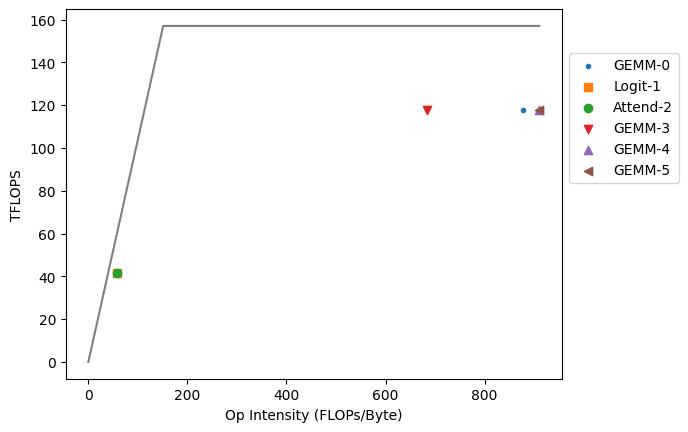

In [4]:
## Coded below is a typical transformer layer. 
B, H, N, D = 1, 16, 1024 , 1024
model_b1ii = [GEMM([B, N, D*3, D ]),
            Logit([B, H, N, N, D//H ]),
            Attend([B, H, N, N, D//H]),
            GEMM([B, N, D, D ]), 
            GEMM([B, N, 4*D, D ]),
            GEMM([B, N, D, 4*D ])]

unoptimized_model = analysis_model(model_b1ii, A100_GPU, fusion = [])
display(unoptimized_model)
dot_roofline(unoptimized_model, A100_GPU)
print(f'Total Cycles:{sum(unoptimized_model.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(unoptimized_model.loc[:, "Total Data (MB)"]):0.2f}')


#### Iteratively find the least number of fusion to optimize the runtime.

In [5]:
optimized_model = analysis_model(model_b1ii, A100_GPU, fusion = [(1,2)])
display(optimized_model)
print(f'Total Cycles:{sum(optimized_model.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(optimized_model.loc[:, "Total Data (MB)"]):0.2f}')

6442450944   157000000000000.0
1073741824   157000000000000.0
1073741824   157000000000000.0
2147483648   157000000000000.0
8589934592   157000000000000.0
8589934592   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 3072, 1024]",C,5.42,877.71,0.05,59910.69,6442.45,1.00,3.00,3.00,7.00,117.75,59910.69,11052.57
1,Logit,"[1, 16, 1024, 1024, 64]",C,3.16,56.89,0.01,9985.12,1073.74,1.00,1.00,16.00,18.00,117.75,9985.12,3157.88
2,Attend,"[1, 16, 1024, 1024, 64]",C,3.16,56.89,0.01,9985.12,1073.74,16.00,1.00,1.00,18.00,117.75,9985.12,3157.88
3,GEMM,"[1, 1024, 1024, 1024]",C,4.22,682.67,0.02,19970.23,2147.48,1.00,1.00,1.00,3.00,117.75,19970.23,4736.81
4,GEMM,"[1, 1024, 4096, 1024]",C,5.62,910.22,0.07,79880.92,8589.93,1.00,4.00,4.00,9.00,117.75,79880.92,14210.44
5,GEMM,"[1, 1024, 1024, 4096]",C,5.62,910.22,0.07,79880.92,8589.93,4.00,4.00,1.00,9.00,117.75,79880.92,14210.44


Total Cycles:259612.99, Total data (MB): 64.00


#### Once fusion operations are finalized, generate the csv file

In [6]:
optimized_model.to_csv('output_b2.csv', index=False)

#### Q. Comment on the type of operations that benefit from operator fusion. Why do you think, operator fusion is able to help in bringing the runtime down?

The type of operators which benefit from fusion is those have small operation intensity. This is because these type of operators would relatively be more likly to get memory bound as less computation running on each byte of data. To enhance efficiency, it is wise to get these fused with other layers to cut down mmeory time. 

## B.2 Dataflow aware roofline

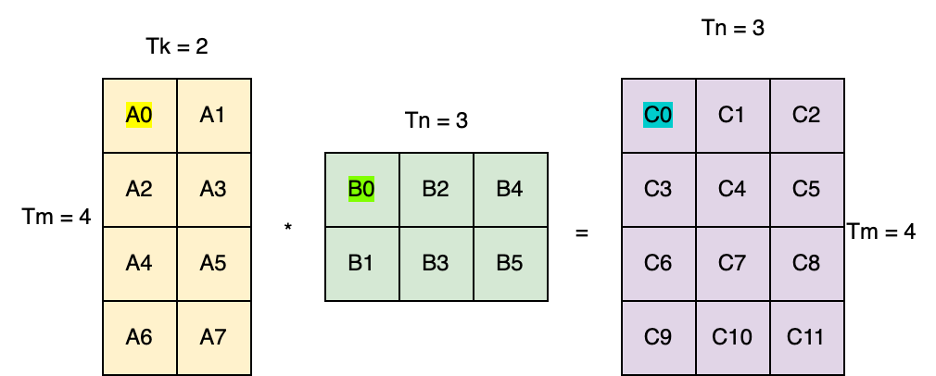

### B.2.i) A stationary
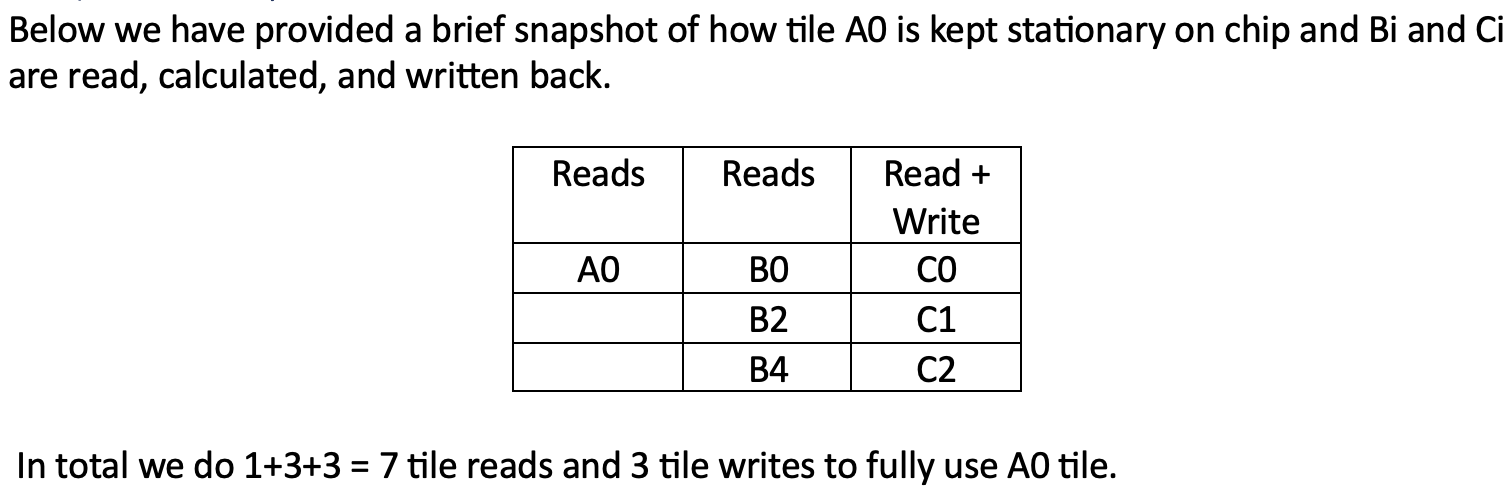

Calculate total number of memory access for A stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

### B.2.ii) B stationary
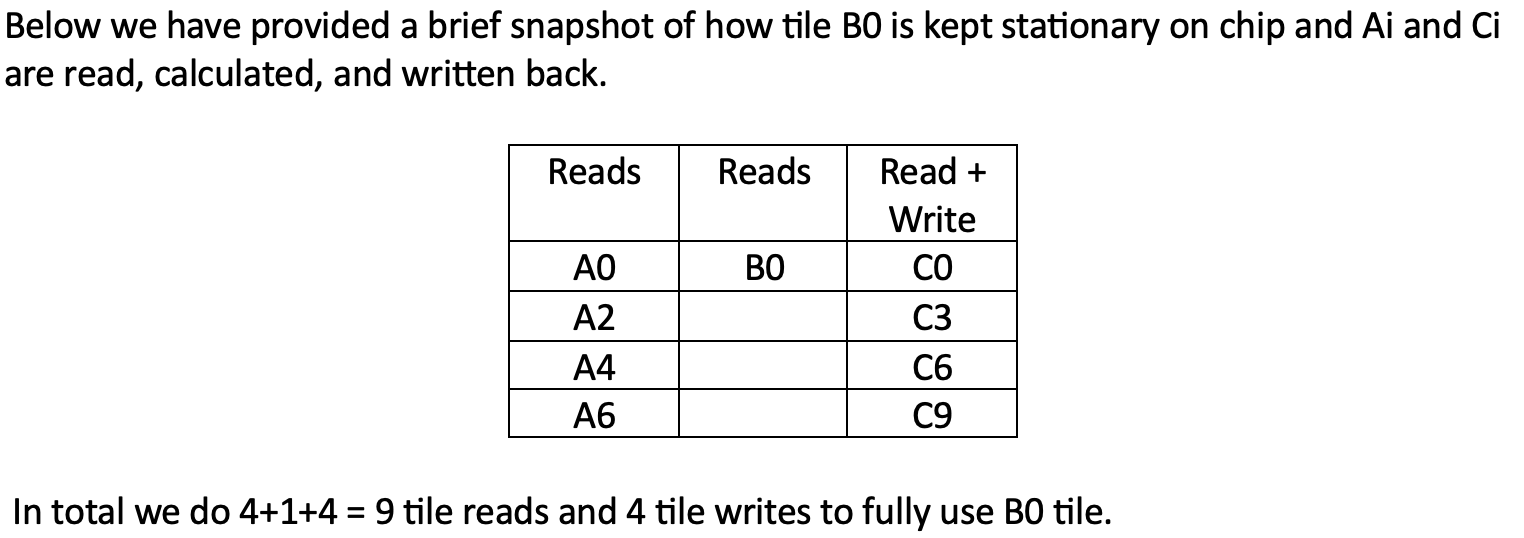

Calculate total number of memory access for B stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

### B.2.iii) C stationary
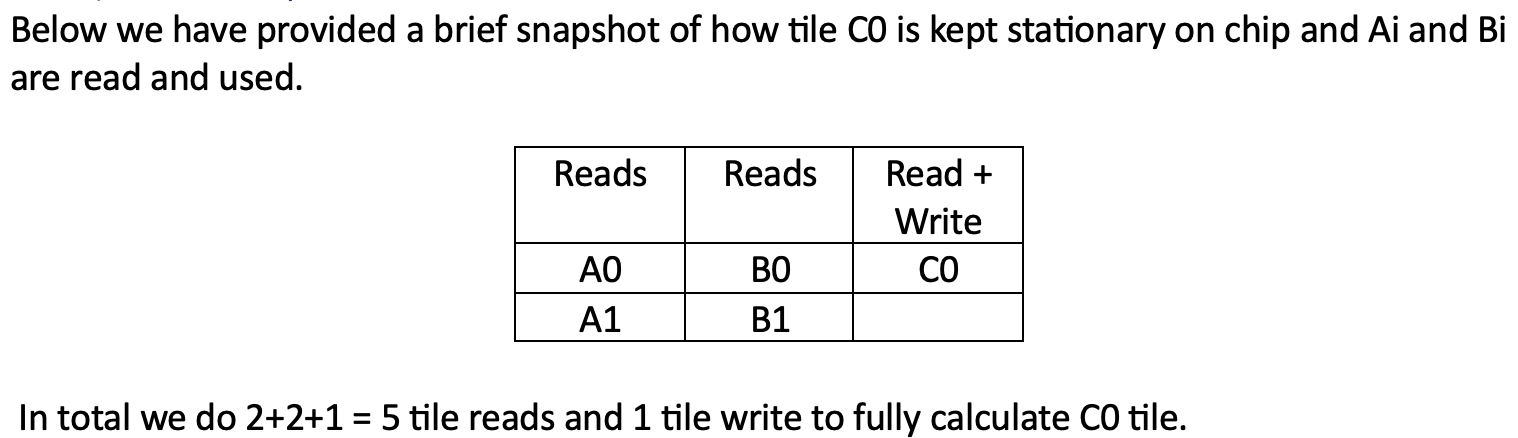

Calculate total number of memory access for C stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

In [7]:
model_b2 = [ GEMM([1, 4096 , 1536, 4096])]
# Size of each tile of A  = 1024 x 2048   = M
# Size of each tile of B = 2048 x 512
# Size of each Output tile = 1024 x 512

model_b2_a_tiling = analysis_model(model_operators = model_b2, system = A100_GPU, tiling = 'A', Tm = 4, Tk = 2, Tn = 3)
display(model_b2_a_tiling)
print(f'Total Cycles:{sum(model_b2_a_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_a_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_b_tiling = analysis_model(model_b2, A100_GPU, tiling = 'B', Tm = 4, Tk = 2, Tn = 3)
display(model_b2_b_tiling)
print(f'Total Cycles:{sum(model_b2_b_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_b_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_c_tiling = analysis_model(model_b2, A100_GPU, tiling = 'C', Tm = 4, Tk = 2, Tn = 3)
display(model_b2_c_tiling)
print(f'Total Cycles:{sum(model_b2_c_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_c_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_a_tiling.to_csv('output_b3a.csv', index=False)
model_b2_b_tiling.to_csv('output_b3b.csv', index=False)
model_b2_c_tiling.to_csv('output_b3c.csv', index=False)

51539607552   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1536, 4096]",C,4.74,1755.43,0.44,479285.52,51539.61,16.00,6.00,6.00,28.00,117.75,479285.52,101052.05


Total Cycles:479285.52, Total data (MB): 28.00
51539607552   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1536, 4096]",C,3.89,1755.43,0.44,479285.52,51539.61,16.00,6.00,6.00,28.00,117.75,479285.52,123157.18


Total Cycles:479285.52, Total data (MB): 28.00
51539607552   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1536, 4096]",C,3.61,1755.43,0.44,479285.52,51539.61,16.00,6.00,6.00,28.00,117.75,479285.52,132630.81


Total Cycles:479285.52, Total data (MB): 28.00


### B.2.iv) Best Tiling
Find the tiling strategy that would require minimum fewer number of memory access compared to these three strategies. 



Explain the strategy by giving example in form a table of reads and write for Ai, Bi, Ci. Also derive the f , g, & h  for the best strategy.


## B.3 Quantization of data

Various datatype possible = bf16, int8, fp32, fp64.

### B.3.i) Quantizing data access 

In [8]:
model_b3 =  [
            GEMM([1, 1024, 128, 512 ]),
            GEMM([1, 128, 256, 128 ]),
            GEMM([1, 1024, 512, 256 ])
            ]

134217728   157000000000000.0
8388608   157000000000000.0
268435456   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.18,0.00,1248.14,134.22,0.50,0.06,0.12,0.69,117.75,1248.14,1085.52
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.40,0.00,123.35,8.39,0.02,0.03,0.03,0.08,74.46,78.01,123.35
2,GEMM,"[1, 1024, 512, 256]",C,1.81,292.57,0.00,2496.28,268.44,0.25,0.12,0.50,0.88,117.75,2496.28,1381.57


Total Cycles:3867.77, Total data (MB): 1.64


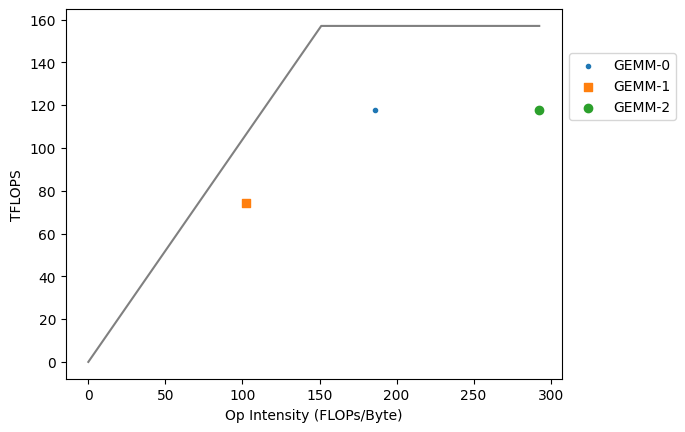

In [9]:
model_b3_bf16 = analysis_model(model_b3, A100_GPU)
display(model_b3_bf16)

dot_roofline(model_b3_bf16, A100_GPU)
print(f'Total Cycles:{sum(model_b3_bf16.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_bf16.loc[:, "Total Data (MB)"]):0.2f}')

134217728   157000000000000.0
8388608   157000000000000.0
268435456   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,2.30,186.18,0.00,1248.14,134.22,0.50,0.06,0.12,0.69,117.75,1248.14,542.76
1,GEMM,"[1, 128, 256, 128]",C,1.26,102.40,0.00,78.01,8.39,0.02,0.03,0.03,0.08,117.75,78.01,61.68
2,GEMM,"[1, 1024, 512, 256]",C,3.61,292.57,0.00,2496.28,268.44,0.25,0.12,0.50,0.88,117.75,2496.28,690.79


Total Cycles:3822.43, Total data (MB): 1.64


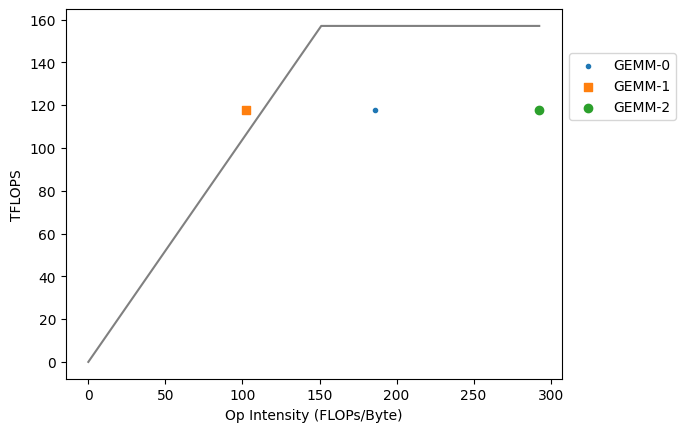

In [10]:
model_b3_int8 = analysis_model(model_b3, A100_GPU, data_format='int8')
display(model_b3_int8)

dot_roofline(model_b3_int8, A100_GPU)
print(f'Total Cycles:{sum(model_b3_int8.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_int8.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_int8.to_csv('output_b4a.csv', index=False)

134217728   157000000000000.0
8388608   157000000000000.0
268435456   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.57,186.18,0.00,2171.04,134.22,0.50,0.06,0.12,0.69,67.69,1248.14,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.32,102.40,0.00,246.71,8.39,0.02,0.03,0.03,0.08,37.23,78.01,246.71
2,GEMM,"[1, 1024, 512, 256]",M,0.90,292.57,0.00,2763.14,268.44,0.25,0.12,0.50,0.88,106.38,2496.28,2763.14


Total Cycles:5180.89, Total data (MB): 1.64


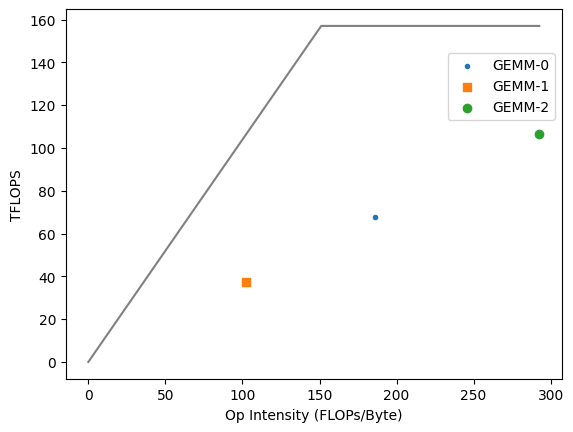

In [11]:
model_b3_fp32 = analysis_model(model_b3, A100_GPU, data_format='fp32')
display(model_b3_fp32)

dot_roofline(model_b3_fp32, A100_GPU)
print(f'Total Cycles:{sum(model_b3_fp32.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp32.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp32.to_csv('output_b4b.csv', index=False)

134217728   157000000000000.0
8388608   157000000000000.0
268435456   157000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.29,186.18,0.00,4342.08,134.22,0.50,0.06,0.12,0.69,33.85,1248.14,4342.08
1,GEMM,"[1, 128, 256, 128]",M,0.16,102.40,0.00,493.42,8.39,0.02,0.03,0.03,0.08,18.62,78.01,493.42
2,GEMM,"[1, 1024, 512, 256]",M,0.45,292.57,0.01,5526.28,268.44,0.25,0.12,0.50,0.88,53.19,2496.28,5526.28


Total Cycles:10361.78, Total data (MB): 1.64


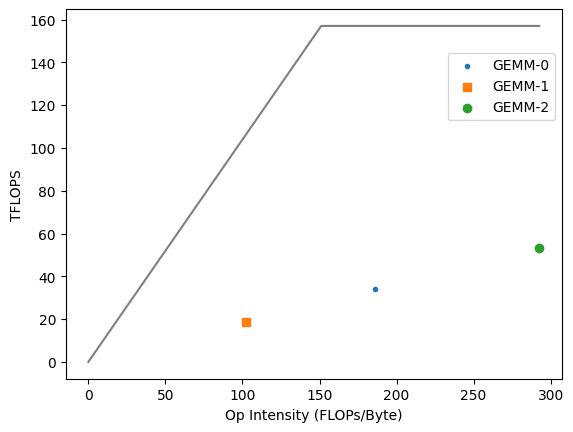

In [12]:
model_b3_fp64 = analysis_model(model_b3, A100_GPU, data_format='fp64')
display(model_b3_fp64)

dot_roofline(model_b3_fp64, A100_GPU)
print(f'Total Cycles:{sum(model_b3_fp64.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp64.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp64.to_csv('output_b4c.csv', index=False)

Q.	Which operations benefit from quantization? Can you identify the scenarios when quantization is useful, and when there is no speedup. Give a brief reasoning on why is that the case.

### B.3.ii) Change in compute ops 

Implement changes in ops_per_sec according to the data format of the model.


Please refer to the below table and scale the system.ops_per_sec for respective data formats.

|BF16 |	Int8 | FP32 | FP64 |
|----|----|----|----|
|X	| X*2 | X/2 | X/4 |


In [13]:
model_b3_int8_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format='int8', compute = True)
display(model_b3_int8_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_int8_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_int8_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_int8_compute_adjusted.to_csv('output_b5a.csv', index=False)

model_b3_fp32_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format='fp32', compute = True)
display(model_b3_fp32_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_fp32_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp32_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp32_compute_adjusted.to_csv('output_b5b.csv', index=False)

model_b3_fp64_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format='fp64', compute = True)
display(model_b3_fp64_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_fp64_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp64_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp64_compute_adjusted.to_csv('output_b5c.csv', index=False)

134217728   314000000000000.0
8388608   314000000000000.0
268435456   314000000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.18,0.00,624.07,134.22,0.50,0.06,0.12,0.69,235.50,624.07,542.76
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.40,0.00,61.68,8.39,0.02,0.03,0.03,0.08,148.93,39.00,61.68
2,GEMM,"[1, 1024, 512, 256]",C,1.81,292.57,0.00,1248.14,268.44,0.25,0.12,0.50,0.88,235.50,1248.14,690.79


Total Cycles:1933.89, Total data (MB): 1.64
134217728   78500000000000.0
8388608   78500000000000.0
268435456   78500000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.18,0.00,2496.28,134.22,0.50,0.06,0.12,0.69,58.88,2496.28,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.40,0.00,246.71,8.39,0.02,0.03,0.03,0.08,37.23,156.02,246.71
2,GEMM,"[1, 1024, 512, 256]",C,1.81,292.57,0.00,4992.56,268.44,0.25,0.12,0.50,0.88,58.88,4992.56,2763.14


Total Cycles:7735.55, Total data (MB): 1.64
134217728   39250000000000.0
8388608   39250000000000.0
268435456   39250000000000.0


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.18,0.00,4992.56,134.22,0.50,0.06,0.12,0.69,29.44,4992.56,4342.08
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.40,0.00,493.42,8.39,0.02,0.03,0.03,0.08,18.62,312.03,493.42
2,GEMM,"[1, 1024, 512, 256]",C,1.81,292.57,0.01,9985.12,268.44,0.25,0.12,0.50,0.88,29.44,9985.12,5526.28


Total Cycles:15471.09, Total data (MB): 1.64


Q.	Which operations benefit from quantization? What do you see speedup in cases? Explain in 1 line why do we speedup in all operations.

Q.	Comment in 1 line,  why models are not quantized to the smallest possible data format if they can give you significant speedups?
